<a href="https://colab.research.google.com/github/fiaazwa/DeepLearning/blob/main/Uji_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn, optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import cv2


In [4]:
# Ganti dengan path dataset di Google Drive
data_dir = '/content/drive/MyDrive/Dataset_DeepLearning'

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_data = datasets.ImageFolder(os.path.join(data_dir, 'training'), transform=transform_train)
val_data   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_val_test)
test_data  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform_val_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

class_names = train_data.classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


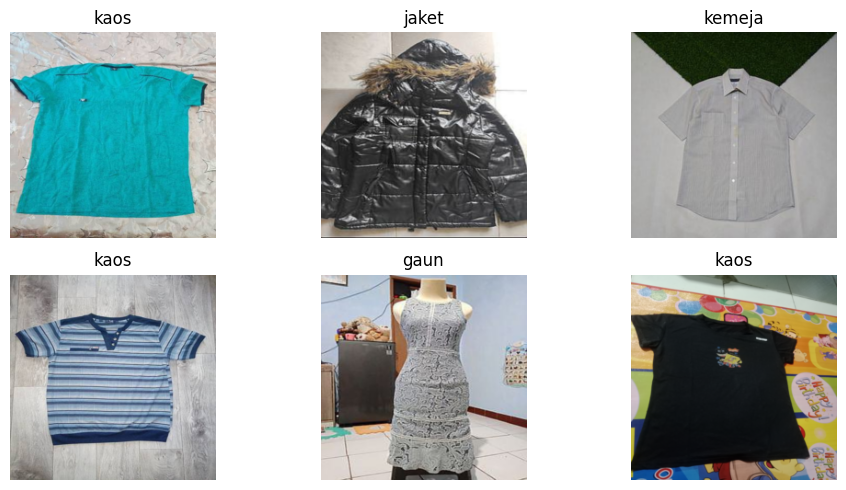

In [5]:
# Visualisasi sample image
def show_images(dataloader):
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(10,5))
    for i in range(6):
        img = images[i] / 2 + 0.5  # Unnormalize
        npimg = img.numpy().transpose((1, 2, 0))
        plt.subplot(2, 3, i+1)
        plt.imshow(npimg)
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images(train_loader)


In [6]:
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 4)  # 4 kelas
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 48.6MB/s]


In [8]:
num_epochs = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")


Epoch [1/50] | Train Loss: 0.3979 | Train Acc: 86.37% | Val Loss: 0.7493 | Val Acc: 77.22%
Epoch [2/50] | Train Loss: 0.1523 | Train Acc: 94.52% | Val Loss: 0.5672 | Val Acc: 85.56%
Epoch [3/50] | Train Loss: 0.0935 | Train Acc: 96.69% | Val Loss: 0.3956 | Val Acc: 84.44%
Epoch [4/50] | Train Loss: 0.0830 | Train Acc: 96.69% | Val Loss: 0.2661 | Val Acc: 91.11%
Epoch [5/50] | Train Loss: 0.0384 | Train Acc: 98.79% | Val Loss: 0.3412 | Val Acc: 89.44%
Epoch [6/50] | Train Loss: 0.0783 | Train Acc: 97.42% | Val Loss: 0.2859 | Val Acc: 90.00%
Epoch [7/50] | Train Loss: 0.0575 | Train Acc: 98.39% | Val Loss: 0.3380 | Val Acc: 90.00%
Epoch [8/50] | Train Loss: 0.0643 | Train Acc: 97.66% | Val Loss: 0.3856 | Val Acc: 88.89%
Epoch [9/50] | Train Loss: 0.0414 | Train Acc: 98.63% | Val Loss: 0.3687 | Val Acc: 90.00%
Epoch [10/50] | Train Loss: 0.0233 | Train Acc: 99.27% | Val Loss: 0.2277 | Val Acc: 91.11%
Epoch [11/50] | Train Loss: 0.0347 | Train Acc: 98.71% | Val Loss: 0.3163 | Val Acc: 89.4

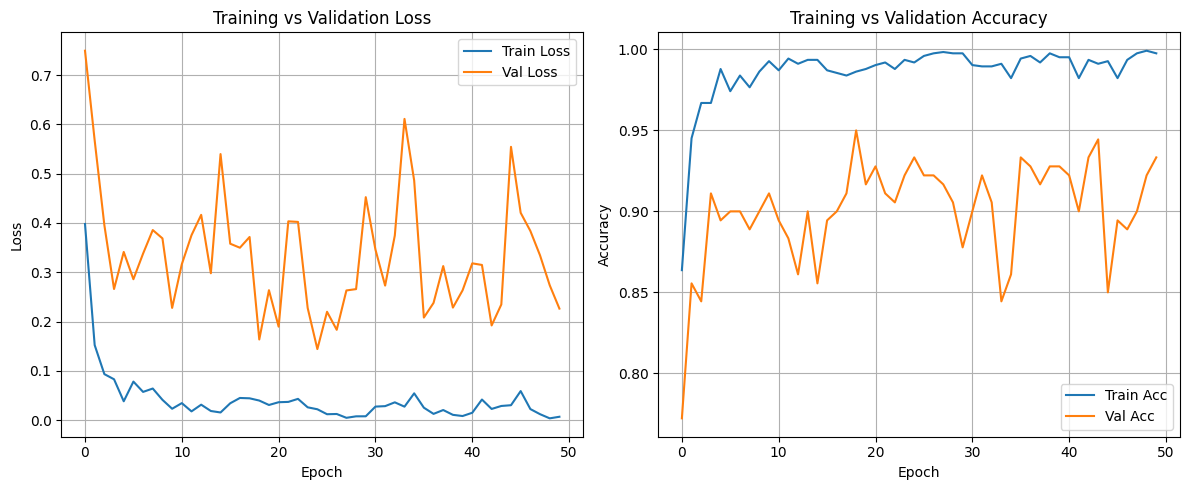

In [9]:
# Visualisasi Loss dan Akurasi
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

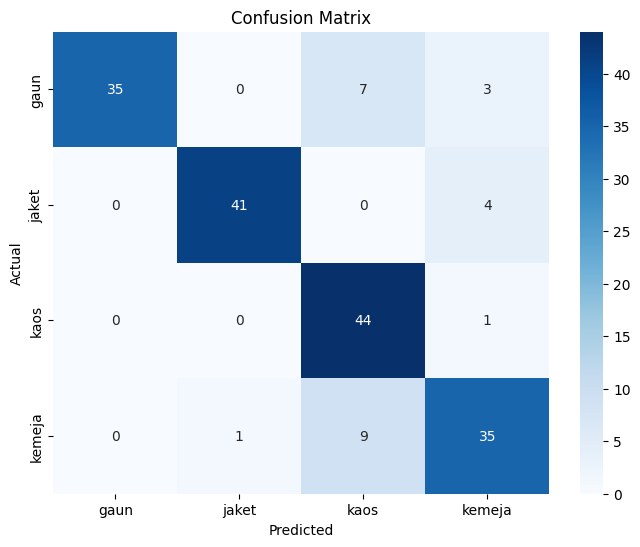

              precision    recall  f1-score   support

        gaun       1.00      0.78      0.88        45
       jaket       0.98      0.91      0.94        45
        kaos       0.73      0.98      0.84        45
      kemeja       0.81      0.78      0.80        45

    accuracy                           0.86       180
   macro avg       0.88      0.86      0.86       180
weighted avg       0.88      0.86      0.86       180



In [18]:
# Confusion Matrix & Model Evaluation
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Shape of grad: torch.Size([1280, 7, 7])
Shape of act: torch.Size([1280, 7, 7])
Shape of pooled_grad: torch.Size([1280])


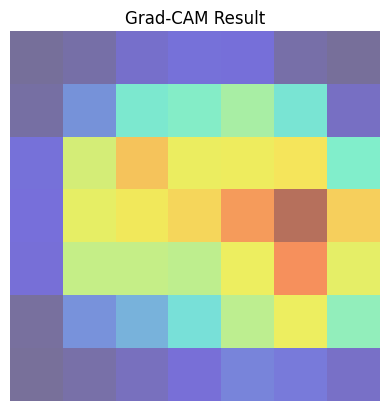

In [17]:
# === Grad-CAM Visualization ===
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# --- Inisialisasi penyimpan ---
activations = {}
gradients = {}

# Fungsi hook
def forward_hook(module, input, output):
    activations['value'] = output

def backward_hook(module, grad_input, grad_output):
    gradients['value'] = grad_output[0]

# Pasang hook di layer terakhir convolution
# target_layer = model.layer4[-1] # Original line causing error
# Get the last layer of the features module
target_layer = model.features[-1]

# Pasang hook
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)  # Ganti yang ini

# Fungsi gradcam
def generate_gradcam(image_tensor, class_idx=None):
    model.eval()
    activations.clear()
    gradients.clear()

    image_tensor = image_tensor.unsqueeze(0).to(device)  # [1, C, H, W]
    output = model(image_tensor)

    if class_idx is None:
        class_idx = torch.argmax(output)

    output[:, class_idx].backward()

    grad = gradients['value'].squeeze(0)        # [C, H, W]
    act = activations['value'].squeeze(0)       # [C, H, W]

    pooled_grad = grad.mean(dim=[1, 2])   # [C]
    print("Shape of grad:", grad.shape)
    print("Shape of act:", act.shape)
    print("Shape of pooled_grad:", pooled_grad.shape)

    for i in range(act.shape[0]):
        act[i] *= pooled_grad[i].item()  # <- Gunakan .item()

    heatmap = act.mean(dim=0).cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-8)

    return heatmap

# ==== Menampilkan hasilnya ====

# Ambil contoh gambar dari test set
sample_img, _ = test_data[0]

# Generate heatmap
heatmap = generate_gradcam(sample_img)

# Konversi gambar asli ke format numpy
img = sample_img.permute(1, 2, 0).cpu().numpy()
img -= img.min()
img /= img.max()

# Tampilkan gambar asli + heatmap
plt.imshow(img)
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
plt.title("Grad-CAM Result")
plt.axis('off')
plt.show()

In [20]:
# === Error Rate Analysis ===
errors = [(p, t) for p, t in zip(y_pred, y_true) if p != t]
print(f"Total Misclassified Samples: {len(errors)}")

Total Misclassified Samples: 25


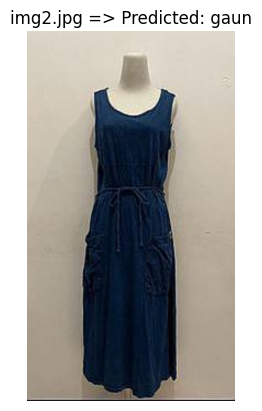

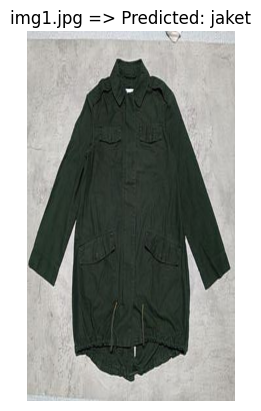

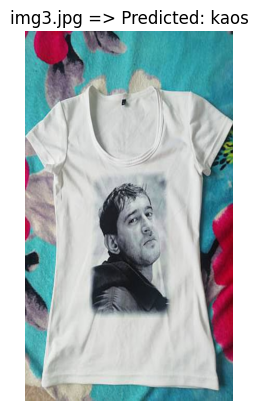

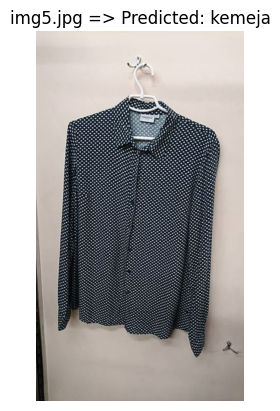

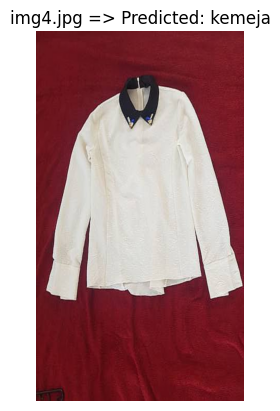

In [28]:
# === Predict New Image ===
import os
from PIL import Image

def predict_from_folder(folder_path, model, transform, class_names):
    model.eval()
    predictions = []

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).convert("RGB")
            img_tensor = transform(img).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(img_tensor)
                _, pred = torch.max(output, 1)
                predicted_class = class_names[pred.item()]
                predictions.append((filename, predicted_class))

    return predictions

predict_path = "/content/drive/MyDrive/Dataset_DeepLearning/predict"
results = predict_from_folder(predict_path, model, transform_val_test, class_names)


# === Tampilkan hasilnya ===
for fname, pred in results:

    # Baca gambar dari folder prediksi
    img_path = os.path.join(predict_path, fname)
    img = Image.open(img_path).convert("RGB")

    # Tampilkan gambar
    plt.imshow(img)
    plt.title(f"{fname} => Predicted: {pred}")
    plt.axis('off')
    plt.show()